### Installation

In [1]:
# %pip install -Uq langchain langchain-community python_dotenv
# %pip install -Uq langchain-openai

In [2]:
# %pip install pandas numpy html5lib
# %pip install -Uq chromadb tiktoken

In [3]:
# %pip install "unstructured[all-docs]<=0.16.10"
# %pip install pillow lxml

In [4]:
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough,RunnableLambda

from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from pathlib import Path
from base64 import b64decode
import uuid

c:\Users\ODUNAYO\Documents\Machine Learning Projects\LLM Project\LangChain General\Document Loader\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
FILE_PATH = Path("data/layout-parser-paper.pdf") 

### Data Extraction

In [ ]:

def data_extraction():

    raw_pdf_elements = partition_pdf(
        filename=FILE_PATH,
      
        infer_table_structure=True,
        strategy = "hi_res",
        
        extract_image_block_types = ["Image"],
        extract_image_block_to_payload  = True,

        chunking_strategy="by_title",
        mode='elements',
        max_characters=10000,
        new_after_n_chars=5000,
        combine_text_under_n_chars=2000,
        image_output_dir_path="data/",
    )
    return raw_pdf_elements

In [9]:
pdf_elements = data_extraction()

In [10]:
pdf_elements

In [12]:
pdf_elements[0].metadata.orig_elements

In [15]:

tables = [element for element in pdf_elements if 'Table' in str(type(element))]
images = [item.metadata.image_base64 for element in pdf_elements for item in element.metadata.orig_elements 
                if "Image" in str(type(item))]
text =   [element for element in pdf_elements if 'Composite' in str(type(element))]

In [6]:
# images[0]

In [20]:
from IPython.display import HTML, display, Image
from PIL import Image
import base64
from io import BytesIO

def plt_img_base64(img_base64):
    img_data = base64.b64decode(img_base64)
    img_buffer = BytesIO(img_data)
    img = Image.open(img_buffer)
    display(img)

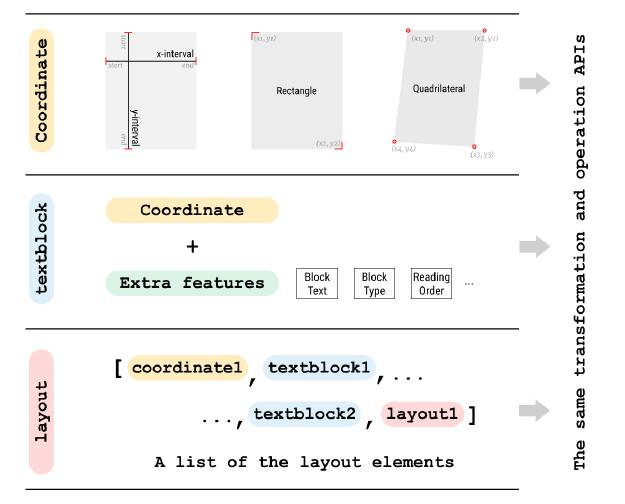

In [22]:
plt_img_base64(images[1])

In [24]:
tables_html = [tb.metadata.text_as_html for tb in tables]

In [5]:
# tables_html

In [29]:
from IPython.display import display, HTML
display(HTML(tables_html[0]))

Dataset,| Base Model'|,| Notes
PubLayNet B8]|,F/M,Layouts of modern scientific documents
PRImA,M,Layouts of scanned modern magazines and scientific report
Newspaper,F,Layouts of scanned US newspapers from the 20th century
TableBank,F,Table region on modern scientific and business document
HJDataset,F/M,Layouts of history Japanese documents


### Summarize the Data

In [31]:
def data_summarize(element):
    prompt_text = """You are an assistant tasked with summarizing text and tables. \
    
                    You are to give a concise summary of the table or text and do nothing else. 
                    Table or text chunk: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)
    model = ChatOpenAI(temperature=0.6, model="gpt-4o-mini")
    summarize_chain = {"element": RunnablePassthrough()}| prompt | model | StrOutputParser()
    summaries = summarize_chain.batch(element, {"max_concurrency": 5})
    return summaries

Text summary

In [36]:
text_summary = data_summarize(text)

In [4]:
# text_summary[0]

Table summary

In [42]:
tables_html

["<table><tr><td>Dataset</td><td>| Base Model'|</td><td>| Notes</td></tr><tr><td>PubLayNet B8]|</td><td>F/M</td><td>Layouts of modern scientific documents</td></tr><tr><td>PRImA</td><td>M</td><td>Layouts of scanned modern magazines and scientific report</td></tr><tr><td>Newspaper</td><td>F</td><td>Layouts of scanned US newspapers from the 20th century</td></tr><tr><td>TableBank</td><td>F</td><td>Table region on modern scientific and business document</td></tr><tr><td>HJDataset</td><td>F/M</td><td>Layouts of history Japanese documents</td></tr></table>",
 '<table><tr><td>block.pad(top, bottom,</td><td>right,</td><td>left)</td><td>Enlarge the current block according to the input</td></tr><tr><td>block.scale(fx, fy)</td><td/><td/><td>Scale the current block given the ratio in x and y direction</td></tr><tr><td>block.shift(dx, dy)</td><td/><td/><td>Move the current block with the shift distances in x and y direction</td></tr><tr><td>block1.is_in(block2)</td><td/><td/><td>Whether block] is 

In [46]:
tables_summary = data_summarize(tables_html)

In [47]:
tables_summary

['The table summarizes various datasets used for layout analysis, along with their base models and descriptions. The datasets include:\n\n1. **PubLayNet B8**: Base Model - F/M; Focuses on layouts of modern scientific documents.\n2. **PRImA**: Base Model - M; Includes layouts of scanned modern magazines and scientific reports.\n3. **Newspaper**: Base Model - F; Contains layouts of scanned US newspapers from the 20th century.\n4. **TableBank**: Base Model - F; Pertains to table regions on modern scientific and business documents.\n5. **HJDataset**: Base Model - F/M; Covers layouts of historical Japanese documents.',
 "The table lists various functions related to block manipulation with their descriptions. Key functions include:\n\n- **block.pad(top, bottom, right, left)**: Enlarges the block.\n- **block.scale(fx, fy)**: Scales the block based on specified ratios.\n- **block.shift(dx, dy)**: Moves the block by specified distances.\n- **block1.is_in(block2)**: Checks if block1 is inside bl

Image summary

In [92]:
def image_summary(images):

    prompt_text = """You are an AI assistant responsible for generating detailed summaries of images 
                        for retrieval purposes. Your task is to describe the image comprehensively.
                          Also, the image may contain tables, graphs, or charts—ensure you
                        accurately summarize their content and significance. Provide a thorough and 
                        structured summary that conveys all relevant details for effective retrieval.  
                        Do not add additional words to it """

    messages = [
        (
            "user",
            [
                {"type": "text", "text": prompt_text},
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{image}"},
                },
            ],
        )
    ]

    prompt = ChatPromptTemplate.from_messages(messages)

    chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()

    image_summaries = chain.batch(images)
    return image_summaries

In [93]:
image_summary = image_summary(images)

In [94]:
image_summary

['The image is a flowchart illustrating the components and processes of the Core LayoutParser Library. \n\n**Sections:**\n\n1. **Model Customization (Left Side):**\n   - **Efficient Data Annotation:** Refers to methods for annotating data effectively for model training.\n   - **Customized Model Training:** Indicates the ability to train models tailored to specific requirements.\n\n2. **Document Images (Center):**\n   - This central element signifies the input for the entire process, which is document images.\n\n3. **Layout Detection Models (Middle):**\n   - The process of detecting the layout of document images is highlighted, showcasing the transition from raw images to structured layout data.\n\n4. **OCR Module (Bottom Left):**\n   - Stands for Optical Character Recognition, which processes the detected layout to extract textual information from images.\n\n5. **Layout Data Structure (Bottom Center):**\n   - Represents how the layout information is organized following detection and OC

#### create Multi-vector Retriever and add Data, Summary to vectorstore

- Store the raw texts, tables, and images in the docstore.
- Store the texts, table summaries, and image summaries in the vectorstore.

In [95]:
def create_retriever(text, text_summary, table, table_summary, image, image_summary):
    # Initialize vector store and in-memory store
    vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
    store = InMemoryStore()
    id_key = "doc_id"

    # Create multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key
    )

    # Helper function to add documents to the retriever
    def add_documents_to_retriever(documents, summaries, retriever):
        if summaries:
            doc_ids = [str(uuid.uuid4()) for _ in documents]
            summary_docs = [
                Document(page_content=summary, metadata={id_key: doc_ids[i]}) 
                for i, summary in enumerate(summaries)
            ]
            retriever.vectorstore.add_documents(summary_docs)
            retriever.docstore.mset(list(zip(doc_ids, documents)))

    # Add text, table, and image summaries to the retriever
    add_documents_to_retriever(text, text_summary, retriever)
    add_documents_to_retriever(table, table_summary, retriever)
    add_documents_to_retriever(image, image_summary, retriever)

    return retriever

In [96]:
retriever = create_retriever(text, text_summary, tables, tables_summary, images, image_summary)

#### check retrieval

In [105]:
query = "Tell me about the Deep Learning(DL)-based approaches"
docs = retriever.invoke(query, limit=5)

In [99]:
for i in docs:
    print(i)

Introduction

Deep Learning(DL)-based approaches are the state-of-the-art for a wide range of document image analysis (DIA) tasks including document image classiﬁcation [11,

2 Z. Shen et al.

37], layout detection [38, 22], table detection [26], and scene text detection [4]. A generalized learning-based framework dramatically reduces the need for the manual speciﬁcation of complicated rules, which is the status quo with traditional methods. DL has the potential to transform DIA pipelines and beneﬁt a broad spectrum of large-scale document digitization projects.

However, there are several practical diﬃculties for taking advantages of re- cent advances in DL-based methods: 1) DL models are notoriously convoluted for reuse and extension. Existing models are developed using distinct frame- works like TensorFlow [1] or PyTorch [24], and the high-level parameters can be obfuscated by implementation details [8]. It can be a time-consuming and frustrating experience to debug, reproduce, and 

In [111]:
query = "What are Layout Detection Models"
docs = retriever.invoke(query)

In [150]:
docs

 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAH7AeADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigDMJJOSeaKSlrc5wooooAKSlpKAFooooAKSlpKAFooooAKSlpKAFooooAKSlpKAFooooAKSlpKAFooooAKmtSfNxngioaltv9d+FKWw47l6iiisTcKSlpKAMy8JNywJ4GMflUFTXn/H0/wCH8qhrJ7nfD4UFJS0lBQ

In [167]:
def separate_docs(docs):
    b64 = []  
    texts = []      

    for element in docs:
        # Case 1: Check if the element is a composite element
        if 'Composite' in str(type(element)):
            texts.append(element)  # Add the composite element to the texts list

            # Check if the composite element contains images in its metadata
            for item in element.metadata.orig_elements:
                if "Image" in str(type(item)): 
                    try:
                        b64.append(item.metadata.image_base64)
                    except AttributeError:
                        print("Warning: Image metadata missing 'image_base64' attribute")

        # Case 2: Check if the element is directly a base64 image
        elif isinstance(element, str):
            try:
                base64.b64decode(element)
                b64.append(element)  
            except Exception as e:
                print(f"Error:{e}")

    return {"Images": b64, "texts": texts}

In [ ]:
def separate_docs(docs): 
    try:
        b64 = [item.metadata.image_base64 for element in docs for item in element.metadata.orig_elements 
                        if "Image" in str(type(item))]
    except:
        b64.append(docs for i in docs b64decode(doc))
    text = [element for element in docs if 'Composite' in str(type(element))]
    return {"Images": b64, "texts": text}

In [113]:
separate_docs(docs)

{'Images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAH4AnEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAoorn73xTJZ3stuPDmu3AjbHmwW6Mj+4JcZH4UAdBRXL/8ACZS/9Cp4j/8AAVP/AIuj/hMpf+hU8R/+Aqf/ABdAHUUVy/8AwmUv/QqeI/8AwFT/AOLo/wCEyl/6FTxH/wCAqf8AxdAHUUVy/wDwmUv

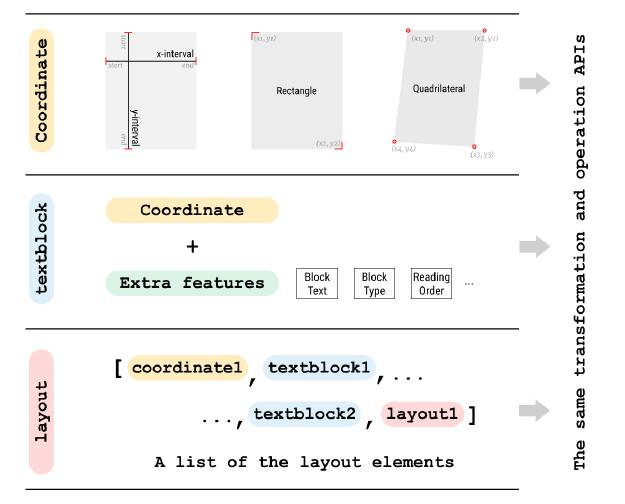

In [115]:
plt_img_base64(separate_docs(docs)['Images'][0])

### RAG Pipeline

In [177]:
def build_prompt(kwargs):
    
    messages = []

    docs  = kwargs['context']
    user_question = kwargs['question']

    # Extract text context
    context_text = "".join(composite.text for composite in docs.get("texts", []))

    #construct prompt with context returned
    prompt_template = f""" 
    You are an AI Assistant tasked with understanding detailed
    information from text, tables and images.
    You are to answer the question based on the context provided to you.
    You must not go beyond the context given to you.
    
    Context: {context_text}
    Question: {user_question}

    """
    #define text mesage
    text_message = {"type": "text", "text": prompt_template}
    messages.append(text_message)

    #Extract image context and define image message
    if docs["Images"]:
       for image in docs["Images"]:
           image_message = {
                   "type": "image_url",
                   "image_url":{"url": f"data:image/jpeg;base64,{image}"},
               }
           messages.append(image_message) 
    
    return [HumanMessage(content=messages)]

 

In [178]:
mrag_with_sources = {
    "context": retriever | RunnableLambda(separate_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response = (
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
) 

In [181]:
query = "Tell me the Current layout detection models in the LayoutParser"
mrag_with_sources.invoke(query)['response']

'The current layout detection models in the LayoutParser model zoo include:\n\n1. **Faster R-CNN (F)** with ResNet 50 backbone\n2. **Faster R-CNN (F)** with ResNet 101 backbone\n3. **Mask R-CNN (M)** with ResNet 50 backbone\n4. **Mask R-CNN (M)** with ResNet 101 backbone\n\nLayoutParser provides a total of 9 pre-trained models trained on 5 different datasets, allowing users to select the most suitable models for their specific tasks based on the training dataset descriptions provided alongside the models.'

In [189]:
def process_rag_output(query):
    response = mrag_with_sources.invoke(query)
    print('Result:')
    print(response['response'])
    print('--'*50)
    display(HTML(response['response']))
    print('--'*50)
    print('Sources:')
    text_sources = response['context']['texts']
    img_sources = response['context']['Images']
    for text in text_sources:
        print('Text Sources')
        print(text.text)
    for img in img_sources:
        ('Image Sources')
        plt_img_base64(img)
        


Result:
The current layout detection models in the LayoutParser model zoo include 9 pre-trained models that have been trained on 5 different datasets. Each model is accompanied by a description of the training dataset, which helps users quickly identify the most suitable models for their tasks. 

While specific model names or details are not mentioned in the provided context, users can also train customized layout models if the pre-trained models do not meet their needs.
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Sources:
Text Sources
1 For each dataset, we train several models of diﬀerent sizes for diﬀerent needs (the trade-oﬀ between accuracy vs. computational cost). For “base model” and “large model”, we refer to using the ResNet 50 or ResNet 101 backbones [13], respectively. One can train models of diﬀerent architectures, like Faster R-CNN [28] (F) and Mask R-CNN [12] (M). For example, an F in the Large Model column indicates it has a Faster R-CNN model trained using the ResNet 101 backbone. The platform is maintained and a number of additions will be made to the model zoo in coming months.

layout data structures, which are optimized for eﬃciency and versatility. 3) When necessary, users can employ existing or customized OCR models via the uniﬁed API provided in the OCR module. 4) LayoutParser comes with a set of utility functions for the visualization and storage of the layout data. 5) Lay

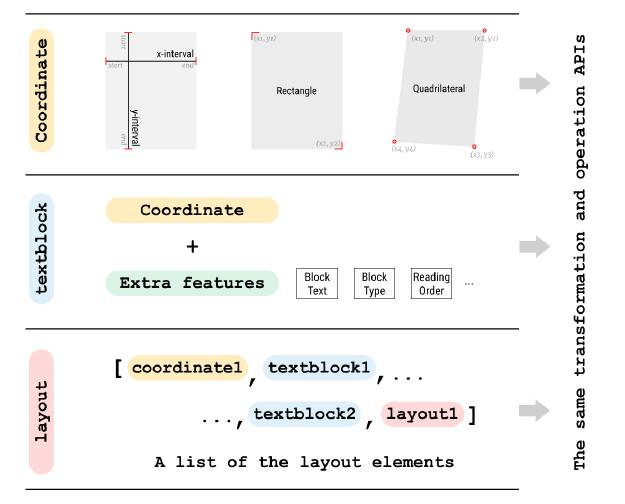

In [183]:
process_rag_output(query)

In [ ]:
# query = "Tell me the Current layout detection models in the LayoutParser"

In [187]:
query ="Tell me about the historical document digitization pipeline"

Result:
The historical document digitization pipeline, as outlined in the provided context, involves several key steps designed to extract structured data from complex documents, particularly historical Japanese financial tables. Here’s an overview of the main components:

1. **Annotate Layout Dataset**: Initial data is curated through an active learning layout annotation toolkit to create a training set.

2. **Layout Detection**: Two object detection models are employed to identify individual columns and tokens within the document. This step addresses challenges such as skewed columns and irregular spacing due to scanning noise.

3. **Post-processing**: After layout detection, errors in predictions are identified and rectified to ensure consistency.

4. **Text Recognition**: Customized OCR models are used to recognize characters. The pipeline employs a document reorganization algorithm to improve recognition accuracy, especially for texts with irregular spacing and unique fonts.

5. *

----------------------------------------------------------------------------------------------------
Sources:
Text Sources
5.1 A Comprehensive Historical Document Digitization Pipeline

The digitization of historical documents can unlock valuable data that can shed light on many important social, economic, and historical questions. Yet due to scan noises, page wearing, and the prevalence of complicated layout structures, ob- taining a structured representation of historical document scans is often extremely complicated.

In this example, LayoutParser was used to develop a comprehensive pipeline, shown in Figure 5, to gener- ate high-quality structured data from historical Japanese ﬁrm ﬁnancial ta- bles with complicated layouts. The pipeline applies two layout models to identify diﬀerent levels of document structures and two customized OCR engines for optimized character recog- nition accuracy.

As shown in Figure 4 (a), the document contains columns of text written vertically 15, a com

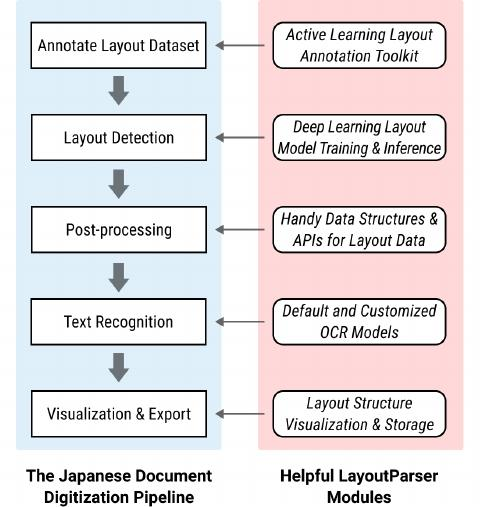

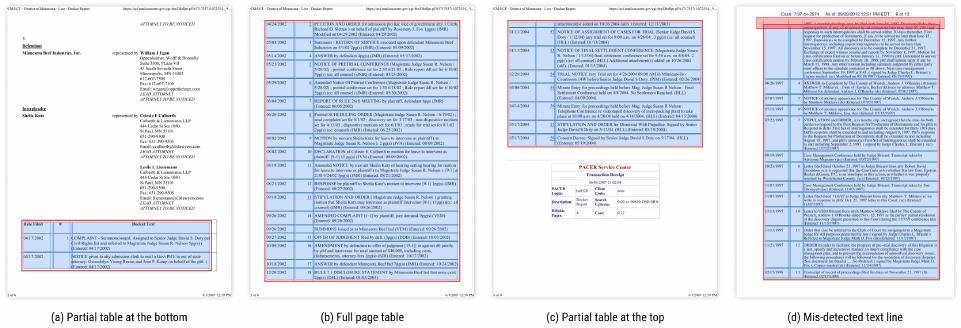

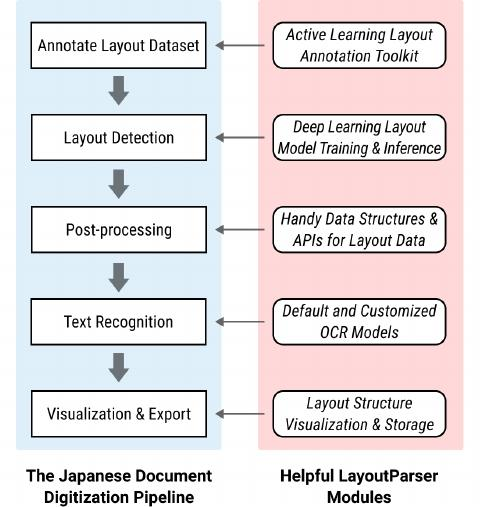

In [190]:
process_rag_output(query)